PAPER Henry Adams et al. “Persistence images: A stable vector representation of persistent homol-
ogy”. In: Journal of Machine Learning Research 18 (2017).

In [8]:
import matplotlib.pyplot as plt
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [ ]:
import time
import os
import pickle
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-darkgrid")
import seaborn as sns
import numpy as np
import gudhi as gd

- CREATE CLASSES FROM A DYNAMICAL SYSTEM WITH DIFFERENT PAIRS OF PARAMETERS
- CREATE THEIR PERSISTENCE DIAGRAM
- COMPARE THEM: WASSERSTEIN AND BOTTOLNECK DISTANCE


> Point clouds generate for the same parameter could be really different

Every time 'generate_orbits' is called the dataset will be saved in "./data/ORBITS/day/time/....csv(and png)"

In [2]:
def generate_orbits(n_points_per_orbit = 1000, params = [2.5, 3.5, 4.0, 4.1, 4.3], same_init_point = True):
    # create point clouds 
    ORBITS = np.zeros([len(params), n_points_per_orbit, 2])
    xcur_0, ycur_0 = np.random.rand(), np.random.rand() # not necesary to save the first one
    for id_pc, param in enumerate(params): # id_point_cloud
        if same_init_point:
            xcur, ycur = xcur_0, ycur_0 # not necesary to save the first one
        else:
            xcur, ycur =np.random.rand(), np.random.rand()
        for id_pt in range(n_points_per_orbit): # id_point
            xcur = (xcur + param * ycur * (1. - ycur)) % 1
            ycur = (ycur + param * xcur * (1. - xcur)) % 1
            ORBITS[id_pc, id_pt, :] = [xcur, ycur]
    return ORBITS

PLOT 1 SAVED at thesis_imgs/pt_cloud_1.pdf


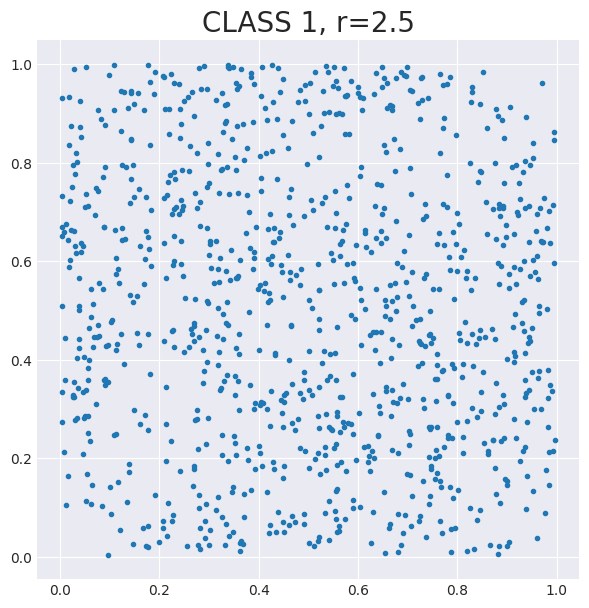

PLOT 2 SAVED at thesis_imgs/pt_cloud_2.pdf


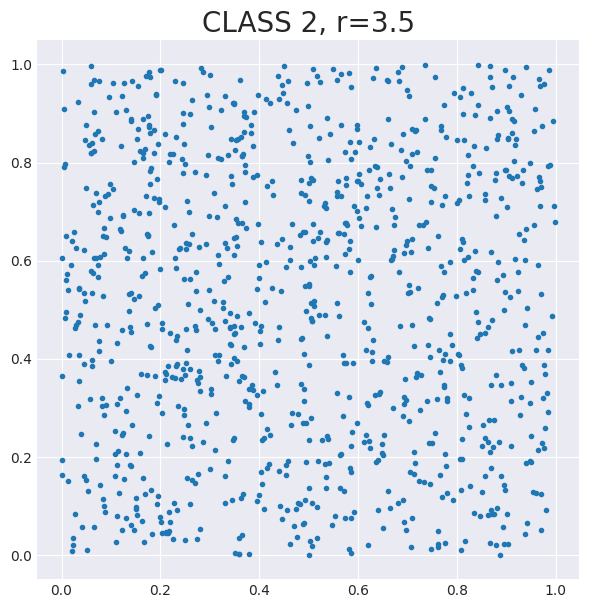

PLOT 3 SAVED at thesis_imgs/pt_cloud_3.pdf


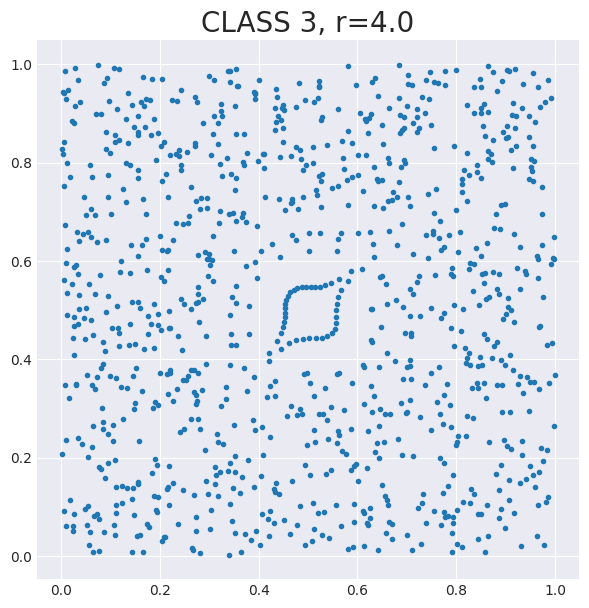

PLOT 4 SAVED at thesis_imgs/pt_cloud_4.pdf


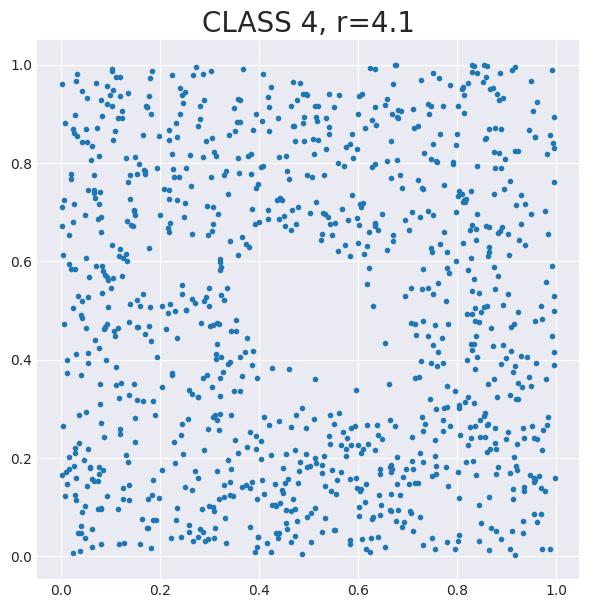

PLOT 5 SAVED at thesis_imgs/pt_cloud_5.pdf


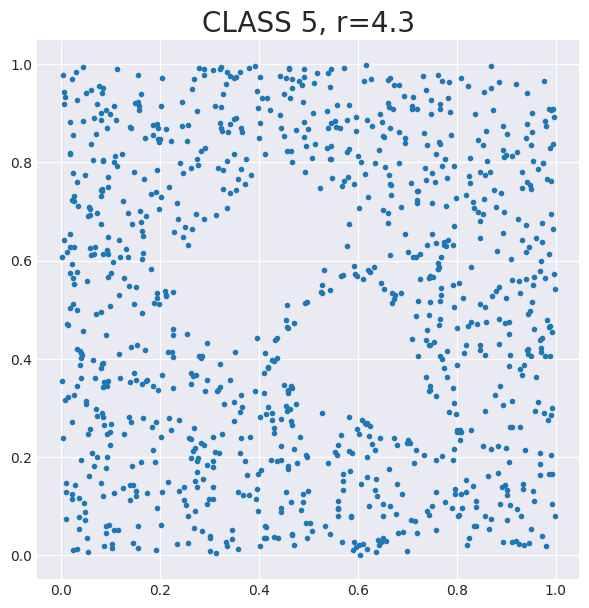

In [3]:
import matplotlib.pyplot as plt
orbits = generate_orbits()
params = [2.5, 3.5, 4.0, 4.1, 4.3]
for i in range(len(params)):  # Loop through each point cloud
    plt.figure(figsize=(7,7))  # Create a new figure for each plot
    
    x = orbits[i, :, 0]
    y = orbits[i, :, 1]
    
    plt.scatter(x, y, s=9)
    plt.title(f'CLASS {i+1}, r={params[i]}', fontsize=20)
    
    plot_path = f"thesis_imgs/pt_cloud_{i+1}.pdf"  # Unique filename for each plot
    plt.savefig(plot_path, format="pdf")
    print(f"PLOT {i+1} SAVED at {plot_path}")
    
    plt.show()


PERSISTENCE DIAGRAMS with APLHA-COMPLEXES


 CLASS 0 	 -------------------------------


/home/andrea/.local/lib/python3.10/site-packages/gudhi/persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


<Figure size 1400x1000 with 0 Axes>

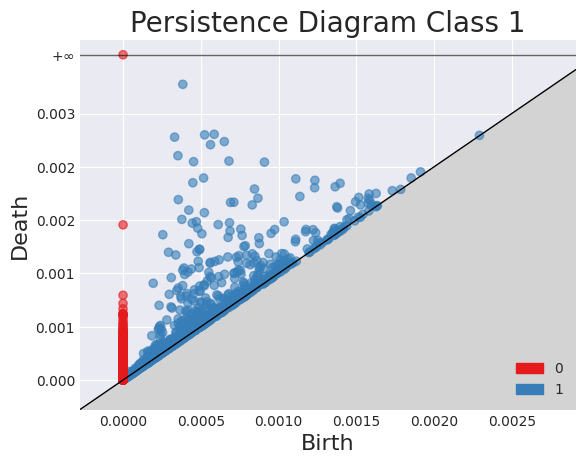


 CLASS 1 	 -------------------------------


<Figure size 1400x1000 with 0 Axes>

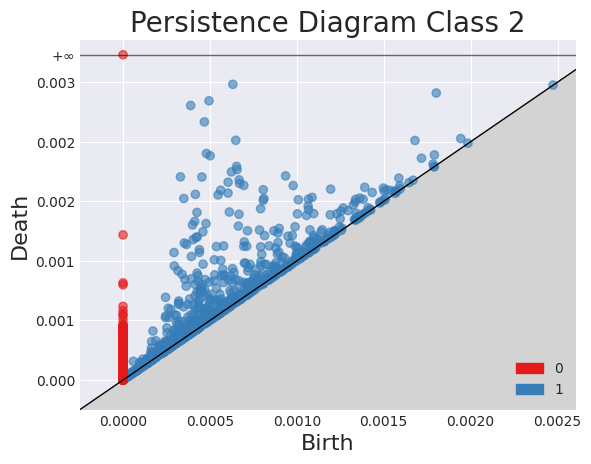


 CLASS 2 	 -------------------------------


<Figure size 1400x1000 with 0 Axes>

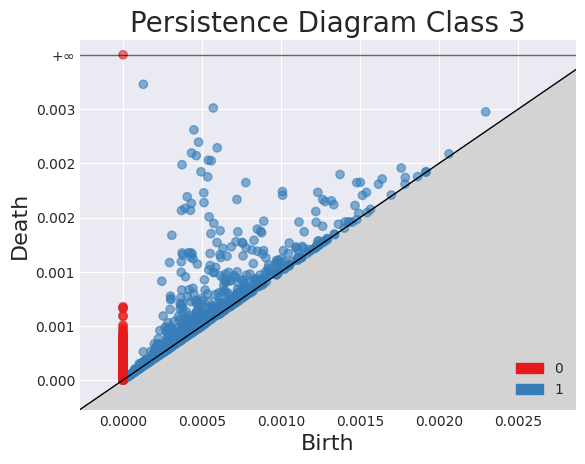


 CLASS 3 	 -------------------------------


<Figure size 1400x1000 with 0 Axes>

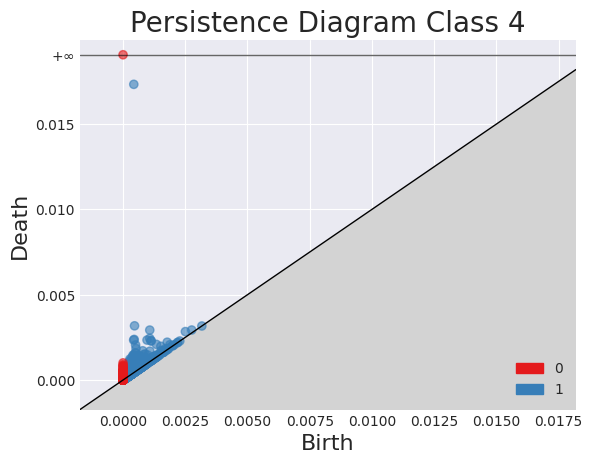


 CLASS 4 	 -------------------------------


<Figure size 1400x1000 with 0 Axes>

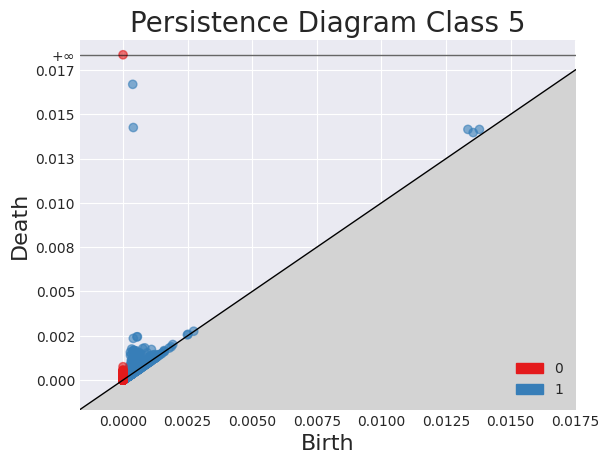

Clouds considered: [0, 1, 2, 3, 4]
5 complexes saved


In [4]:
plot_pd = True
persistences = {}

considered_clouds = sorted([0,1,2,3,4])

for i in considered_clouds:
    print(f"\n CLASS {i} \t -------------------------------")
    ac = gd.AlphaComplex(points=orbits[i,:,:])
    st = ac.create_simplex_tree()
    pers = st.persistence()

    plt.figure(figsize=(14, 10))
    gd.plot_persistence_diagram(pers)
    plt.title(f"Persistence Diagram Class {i+1}", fontsize=20)
    plt.xlabel("Birth", fontsize=16)  # X-axis label
    plt.ylabel("Death", fontsize=16)  # Y-axis label
    plt.savefig(f"./thesis_imgs/pt_cloud_{i+1}_PD.pdf", format="pdf")
    plt.show()

    pers_dict = {
        'skeleton': ac,
        'complex': st,
        'persist': pers
    }
    persistences[i] = pers_dict
print(f"Clouds considered: {considered_clouds}\n{len(persistences)} complexes saved")

In [5]:
from itertools import product
from gudhi.wasserstein import wasserstein_distance

dimension_considered = 0
considered_clouds = sorted(considered_clouds)
# pairs of clouds

# all_pairs = list(filter(lambda x: x[0] <= x[1], product(persistences.keys(), repeat=2)))
all_pairs = list(product(persistences.keys(), repeat=2))
type_dist = 'bott'
dists = {}
for cl in considered_clouds: #init spots in the dict for distances
    dists[cl] = []

for idx, pair in enumerate(all_pairs):

    I0 = persistences[pair[0]]["complex"].persistence_intervals_in_dimension(dimension_considered)
    I1 = persistences[pair[1]]["complex"].persistence_intervals_in_dimension(dimension_considered)

    if type_dist == 'wass':
        dist = wasserstein_distance(I0, I1)
    else:
        dist = gd.bottleneck_distance(I0, I1)
        # gd.bottleneck_distance(I0, I1, 0.01) possible approximation
    dists[pair[0]].append(dist)

# visualize matrix of distances
print(f">>> Considered Dimension = {dimension_considered}")
print(f">>> \t DISTANCE = {type_dist}\n")
for k in dists.keys():
    print(f"{k} |", end='')
    vals = dists[k]
    print(f" - -  - - |"*(len(considered_clouds)-len(vals)), end='')
    for v in vals:
        print(f" {v:.6f} !",end='')
    print()

>>> Considered Dimension = 0
>>> 	 DISTANCE = bott

0 | 0.000000 ! 0.000238 ! 0.000728 ! 0.000452 ! 0.000706 !
1 | 0.000238 ! 0.000000 ! 0.000542 ! 0.000214 ! 0.000468 !
2 | 0.000728 ! 0.000542 ! 0.000000 ! 0.000328 ! 0.000118 !
3 | 0.000452 ! 0.000214 ! 0.000328 ! 0.000000 ! 0.000318 !
4 | 0.000706 ! 0.000468 ! 0.000118 ! 0.000318 ! 0.000000 !


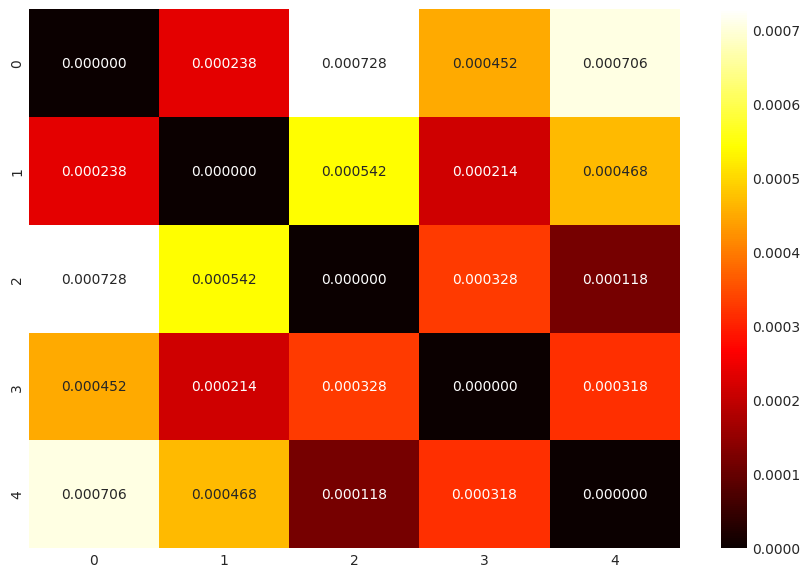

In [9]:
import seaborn as sns

data = []
for key in dists.keys():
    vals = dists[key]
    dat = [0]*(len(considered_clouds)-len(vals)) + vals
    data.append(dat)

plt.figure(figsize=(3 + 1.5*len(considered_clouds), 2 + 1*len(considered_clouds)))

# Plotting the heatmap with annotations
sns.heatmap(data, cmap='hot', annot=True, fmt=".6f", xticklabels=considered_clouds, yticklabels=considered_clouds, cbar=True)
plt.savefig(f"./thesis_imgs/pt_cloud_distances_PD.pdf", format="pdf")
plt.show()

> PD inspection

In [7]:
len(persistences)
for i in persistences:
    print(f'\n### {i = } ###')
    pers = persistences[i]["persist"]
    compl = persistences[i]["complex"]
    print(f'{len(pers) = }')
    print(f'{len(compl.persistence_intervals_in_dimension(0)) = }')
    print(f'{len(compl.persistence_intervals_in_dimension(1)) = }')
    print(pers[len(compl.persistence_intervals_in_dimension(1))-1:len(compl.persistence_intervals_in_dimension(1))+1])
    print(pers[-3:])



### i = 0 ###
len(pers) = 1939
len(compl.persistence_intervals_in_dimension(0)) = 1000
len(compl.persistence_intervals_in_dimension(1)) = 939
[(1, (0.0002722882218186008, 0.00027228837801543675)), (0, (0.0, inf))]
[(0, (0.0, 4.1118961078670163e-07)), (0, (0.0, 2.1749859311671083e-07)), (0, (0.0, 9.841085353299703e-08))]

### i = 1 ###
len(pers) = 1918
len(compl.persistence_intervals_in_dimension(0)) = 1000
len(compl.persistence_intervals_in_dimension(1)) = 918
[(1, (0.0005435831230927405, 0.0005435831905299538)), (0, (0.0, inf))]
[(0, (0.0, 5.182693020150252e-07)), (0, (0.0, 4.744353664382797e-07)), (0, (0.0, 3.117363630655684e-07))]

### i = 2 ###
len(pers) = 1920
len(compl.persistence_intervals_in_dimension(0)) = 1000
len(compl.persistence_intervals_in_dimension(1)) = 920
[(1, (0.0009740055976676584, 0.0009740056285521367)), (0, (0.0, inf))]
[(0, (0.0, 4.3172980988016126e-07)), (0, (0.0, 2.710064280843654e-07)), (0, (0.0, 2.393344824156393e-07))]

### i = 3 ###
len(pers) = 1916
len(